# COX Proportional Hazards Model Summary  

This notebook contains the code for generating figure 1, as well as supplementary data tables 1-16.

The Cox proportional hazards models were generated for the outcomes Type 1 diabetes diagnosis (T1D), islet autoantibody detection (IA), first appearing islet autoantibody - insulin (IAA) or glutamic acid decarboxylase (GADA), celiac disease diagnosis (CD) and celiac disease autoantibody detection (CDA). The models were fitted for tri-SNP dosage (0, 1 or 2) along with covariates: sex, having a first degree relative with disease (T1D or CD, depending on the outcome tested), genetic ancestry, HLA type, country, gluten intake (CD and CDA only) and SNPS previously associated with the outcome. The code generating models are provided for supplementary figures 1-12. Saved models are loaded in this notebook to generate a summary figure.

Model summaries for the tri-SNP regression were provided as supplementary data tables 1-12. In addition, summaries for the models fitting DR3-B8 haplotype are also provided in supplementary data tables 13-16.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import warnings
warnings.filterwarnings("ignore")
import session_info

session_info.show(html=False)

-----
matplotlib          3.9.4
numpy               1.26.4
pandas              1.5.3
session_info        1.0.0
-----
IPython             8.18.1
jupyter_client      8.6.3
jupyter_core        5.8.1
jupyterlab          4.4.5
notebook            7.4.5
-----
Python 3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:27:35) [Clang 11.1.0 ]
macOS-15.6.1-x86_64-i386-64bit
-----
Session information updated at 2025-09-18 16:33


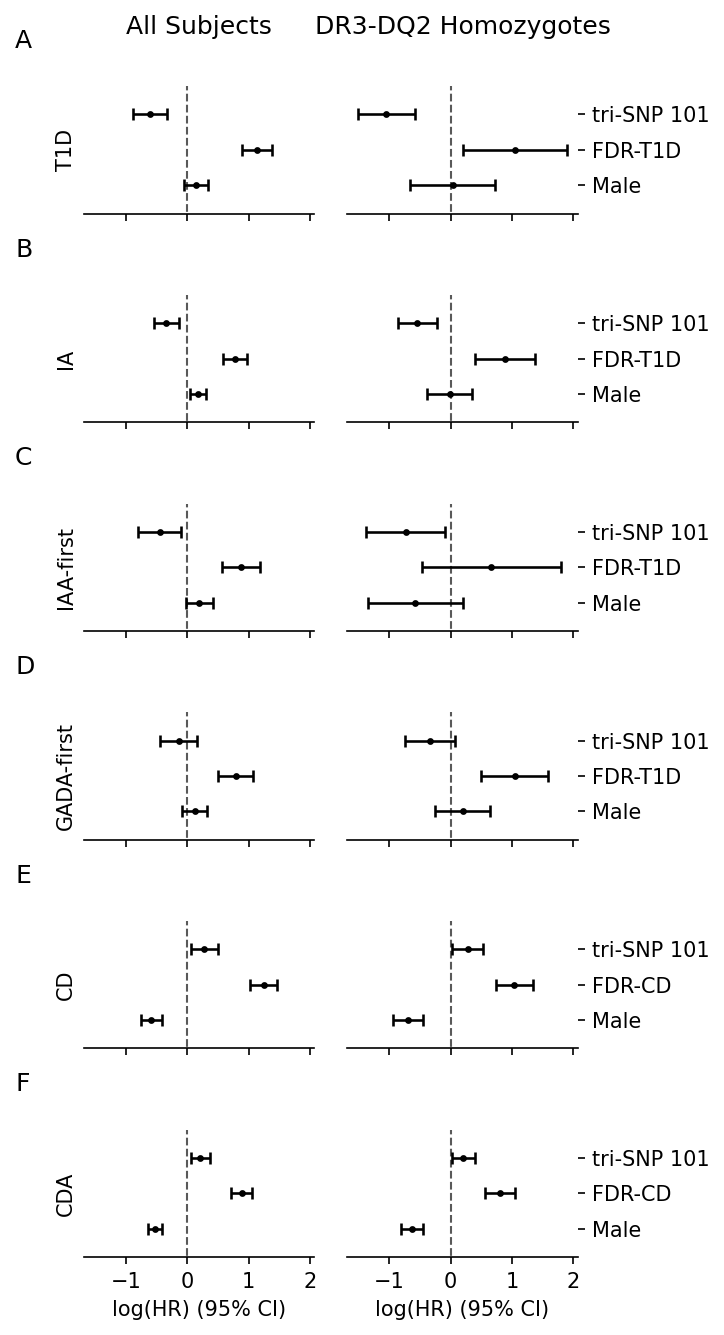

In [3]:
# keep model outcome summaries in a dictionary to create an excel file at the end
summary = {}

# list outcomes
models = ["t1d", "ia", "iaa", "gada", "cd", "cda"]

# each outcome was modeled for all samples as well as dr3 homozygotes
samples = ["all", "dr3"]

# model titles for the plot
titles = ["T1D", "IA", "IAA-first", "GADA-first", "CD", "CDA"]

# create figure with 12 subplots (6 rows and 2 columns)
# each row an outcome and colums for all samples or the dr3 subset
fig, axes = plt.subplots(nrows=len(models), 
                         ncols=len(samples),
                         sharex=True)

# load the model for each outcome/sample set
for i in range(len(models)):
    for j in range(len(samples)):
        with open("../data/CPH_models/cox_" + models[i] + "_" + samples[j] 
                  + "_samples_cph.pickle", "rb") as infile:
            cph = pickle.load(infile)
        ax = axes[i, j]
        # For this figure we plot the main finding (tri-SNP)
        # along with sex and FDR covariates only
        if models[i].startswith("cd"):
            covars = ["tri-SNP 101", "FDR-CD", "Male"]
        else:
            covars = ["tri-SNP 101", "FDR-T1D", "Male"]
        # plot the model using lifelines cph object's plot method
        cph.plot(ax=ax, columns=covars, hazard_ratios=False, 
                 ms=2, fmt="o", markerfacecolor="k")

        # remove the frame around subplot
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        # move ticks to the right. These will have covariate names
        ax.yaxis.tick_right()
        # remove y tick labels from the left panel.
        # instead, use the space for figure panel labeling (A, B, C, etc)
        if j == 0:
            ax.tick_params(left=False, right=False, axis="y")
            ax.set_yticklabels([])
            ax.set_ylabel(titles[i])
            ax.text(x=-0.3, y=1.3, s=chr(i+65),
                    transform=ax.transAxes, fontsize=12)
        
        if i == 0:
            ax.set_title(["All Subjects", "DR3-DQ2 Homozygotes"][j], pad=25)
        if i != len(models) -1:
            ax.set_xlabel("")
        ax.autoscale(True, axis="y")
        ax.margins(y=-0.2)

        # add model output to summary dictionary
        summary[models[i] + "_" + samples[j]] = cph.summary.reset_index()
        
plt.xticks(np.arange(-1,3))
fig.set_dpi(150)
fig.set_size_inches(5, 9)
fig.tight_layout(h_pad=0.5, w_pad=1.5)

# save figure as pdf and png
fig.savefig("figure_1_model_summary.pdf")
fig.savefig("figure_1_model_summary.png", facecolor="w")

### Save model output to excel
This file is the supplementary data tables file.

We'll do some formatting before file save.

In [4]:
summary.keys()

dict_keys(['t1d_all', 't1d_dr3', 'ia_all', 'ia_dr3', 'iaa_all', 'iaa_dr3', 'gada_all', 'gada_dr3', 'cd_all', 'cd_dr3', 'cda_all', 'cda_dr3'])

The order of the tables is slightly different in the paper (iaa comes after gada).  
We'll change the order to match that as well as format the text of the columns as below.  


In [5]:
sorted_keys = ['t1d_all', 't1d_dr3', 'ia_all', 'ia_dr3', 'gada_all', 'gada_dr3',
               'iaa_all', 'iaa_dr3', 'cd_all', 'cd_dr3', 'cda_all', 'cda_dr3']

In [6]:
col_info = pd.DataFrame.from_dict({"covariate": {"column": "covariate", "key": "covariate name"},
            "coef": {"column": "log(HR)", "key": "log2 of Hazard Ratio"},
            "exp(coef)": {"column": "HR", "key": "Hazard Ratio"},
            "se(coef)": {"column": "SE(log(HR))", "key": "Standard Error for log(HR)"},
            "coef lower 95%": {"column": "log(HR) lower 95%", "key": "Lower limit of 95% confidence interval for log(HR)"},
            "coef upper 95%": {"column": "log(HR) upper 95%", "key": "Upper limit of 95% confidence interval for  log(HR)"},
            "exp(coef) lower 95%": {"column": "HR lower 95%", "key": "Lower limit of 95% confidence interval for HR"},
            "exp(coef) upper 95%": {"column": "HR upper 95%", "key": "Upper limit of 95% confidence interval for HR"},
            "z": {"column": "z", "key": "z-score of log(HR)"},
            "p": {"column": "p", "key": "p-value"},
            "-log2(p)": {"column": "-log2(p)", "key": "-log2 of p-value"}}, orient="index").reset_index()
col_info

,index,column,key
0,covariate,covariate,covariate name
1,coef,log(HR),log2 of Hazard Ratio
2,exp(coef),HR,Hazard Ratio
3,se(coef),SE(log(HR)),Standard Error for log(HR)
4,coef lower 95%,log(HR) lower 95%,Lower limit of 95% confidence interval for log...
5,coef upper 95%,log(HR) upper 95%,Upper limit of 95% confidence interval for lo...
6,exp(coef) lower 95%,HR lower 95%,Lower limit of 95% confidence interval for HR
7,exp(coef) upper 95%,HR upper 95%,Upper limit of 95% confidence interval for HR
8,z,z,z-score of log(HR)
9,p,p,p-value


Save model summaries to excel file

In [7]:
writer = pd.ExcelWriter('summary.xlsx')
# write first sheet containing column keys
col_info[["column", "key"]].to_excel(writer, sheet_name="Key", index=None)

# 
for i in range(len(sorted_keys)):
    # get table key, e.g. t1d_all
    table_key = sorted_keys[i]
    # split key and convert the case to get T1D All or T1D DR3
    table_text = table_key.split("_")
    outcome = table_text[0].upper()
    if table_text[1]  == "all":
        samples = "All"
    else:
        samples = "DR3"
    # change table name to, for example, Table 1. T1D All
    table_name = "Table {}. {} {}".format(i+1, outcome, samples)
    # change table column names and save to excel
    summary[table_key].rename(columns=dict(zip(col_info["index"],
                                       col_info["column"]))).to_excel(
        writer, sheet_name=table_name, index=None)

#### Add model summaries for B8 fit
Models fitted using DR3-B8 extended haplotype were not included in the figures but their summaries are included in the supplementary data tables 13-16. We'll add those model summaries below before saving the supplementary data file.

In [8]:
# list outcomes
models = ["t1d", "ia", "cd", "cda"]

# models for all samples only
samples = ["all"]

# load the model for each outcome
for i in range(len(models)):
    for j in range(len(samples)):
        with open("../data/CPH_models/cox_" + models[i] + "_" + samples[j] 
                  + "_samples_b8_cph.pickle", "rb") as infile:
            cph = pickle.load(infile)
        
        # get model summary
        model_sum = cph.summary.reset_index()
        # name table - starting from table 13
        outcome = models[i].upper()
        table_name = "Table {}. B8 {}".format(i+13, outcome)
        # change table column names and save to excel
        model_sum.rename(columns=dict(zip(col_info["index"],
                                          col_info["column"]))).to_excel(
            writer, sheet_name=table_name, index=None)


Save and close the excel file

In [9]:
writer.close()